# ADAS Question Analysis

## Introduction

In this section, we take a closer look at the breakdown of responses to the ADAS-13 questionnaire. We saw in the EDA that the ADAS scores were among the most significant predictors in our various baseline models. We will examine whether certain questions in the questionnaire play a greater role in diagnoses than others.

In [92]:
# ====================
# Import libaries
# ====================

# Core
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm import tqdm
from IPython.display import Image
from IPython.display import display

# skcikit-learn
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import roc_curve, auc

# UDF
from utils.helpers import GridSearchPipe

In [93]:
colors = ["windows blue", "faded green", "greyish", "maroon", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
c3=sns.color_palette()[3]
c4=sns.color_palette()[4]

In [94]:
# Read data
data = pd.read_csv('../data/data_all.csv', low_memory=False);

# Create 'year' variable
data['YEAR'] = data['EXAMDATE'].apply(lambda x: x[:4])

# Subset data to baseline observations for ADNI 1
data = data.loc[(data['VISCODE'] == "bl") & (data['ORIGPROT'] == "ADNI1"), :]

In [95]:
y = data["DX_bl"]
adas_questions = ([x for x in data.columns if "ADAS_Q" in x])

X = data[adas_questions]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
# y_train.unique()

## Gradient Boost

We will first use a gradient boosted model to determine the effect of individual questions on each diagnosis class, by looking at the partial dependence plots.

In [97]:
# =========================
# Fit classification models
# =========================

# Estimators
models = {'GBM': GradientBoostingClassifier()}
# Parameters
params = {'GBM': {'learning_rate': [0.05, 0.1, 0.15, 0.2], 'n_estimators': [5 * x for x in range(2, 10)]}}
 
# Grid search
gsp = GridSearchPipe(models, params)
gsp.fit(X_train, y_train, cv=10, refit=True, verbose=0)
res = gsp.score_summary()
res[:10]

/Users/justinlee/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,mean_score,max_score,std_score,learning_rate,n_estimators
2,GBM,0.631579,0.728562,0.796296,0.050632,0.05,20
9,GBM,0.631579,0.724926,0.814815,0.056905,0.10,15
10,GBM,0.631579,0.724926,0.814815,0.060836,0.10,20
6,GBM,0.631579,0.724926,0.814815,0.065114,0.05,40
25,GBM,0.631579,0.724924,0.796296,0.051825,0.20,15
7,GBM,0.631579,0.724893,0.796296,0.063120,0.05,45
18,GBM,0.618182,0.723075,0.796296,0.062154,0.15,20
17,GBM,0.631579,0.723041,0.796296,0.058960,0.15,15
8,GBM,0.631579,0.723006,0.796296,0.047902,0.10,10
5,GBM,0.631579,0.721289,0.814815,0.061748,0.05,35


In [102]:
cv_gbm = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20)
cv_gbm.fit(X_train, y_train)

cv_gbm.score(X_test, y_test)

0.66789667896678961

Based on the results of our bootstrapping, we use a learning rate of 0.1 with 20 estimators to train our GBM. This gives us an accuracy of 0.668.

**************************************************


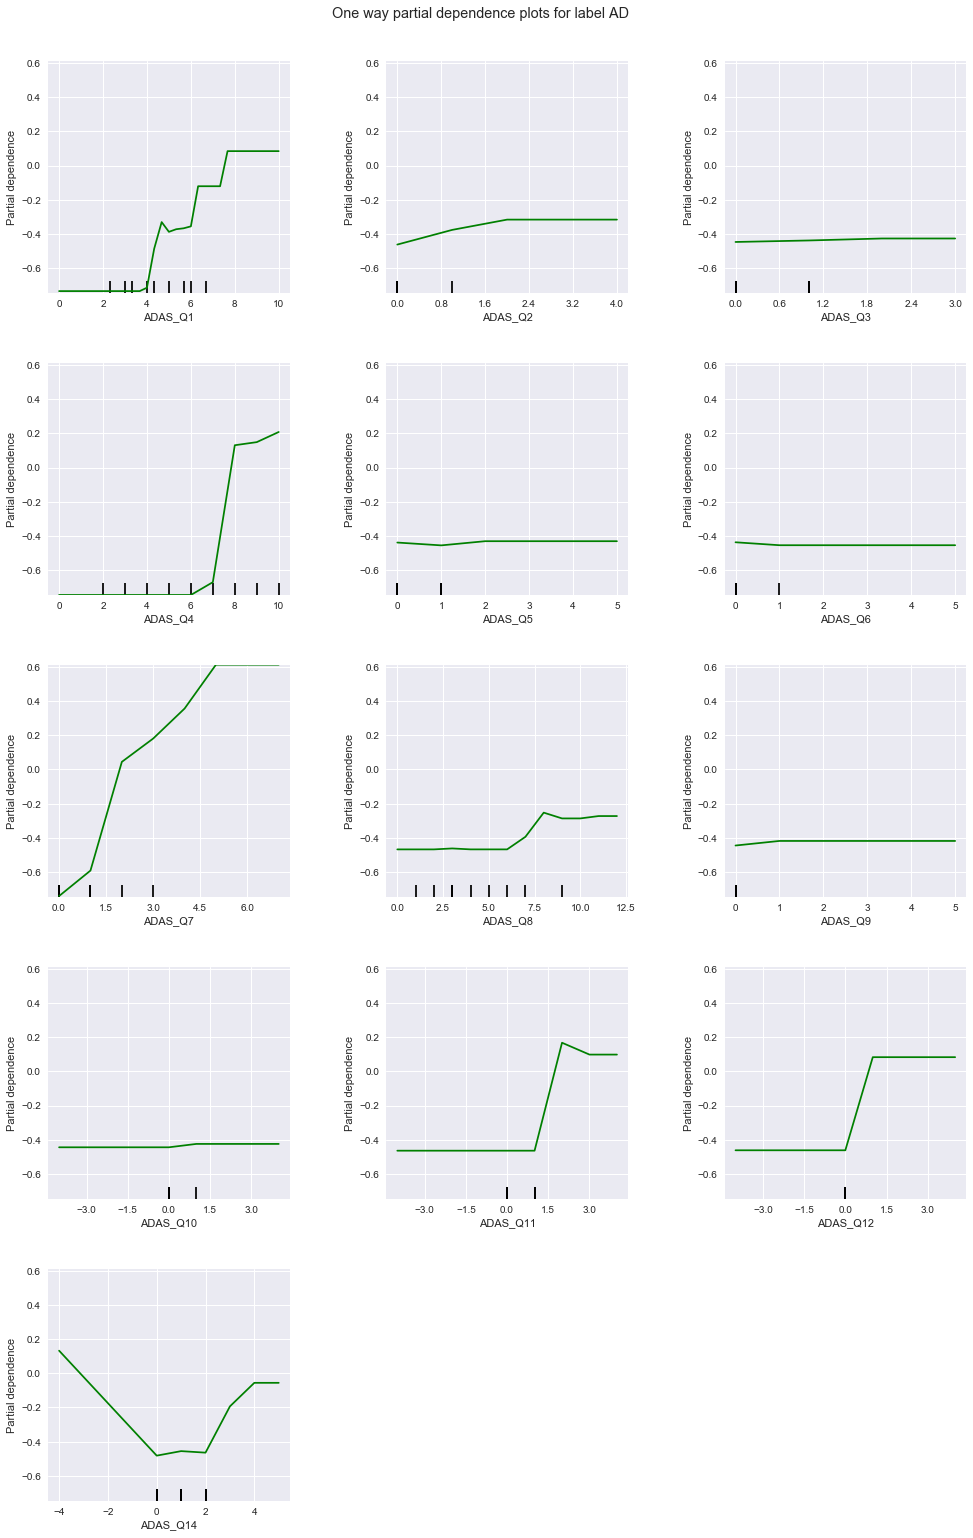

**************************************************


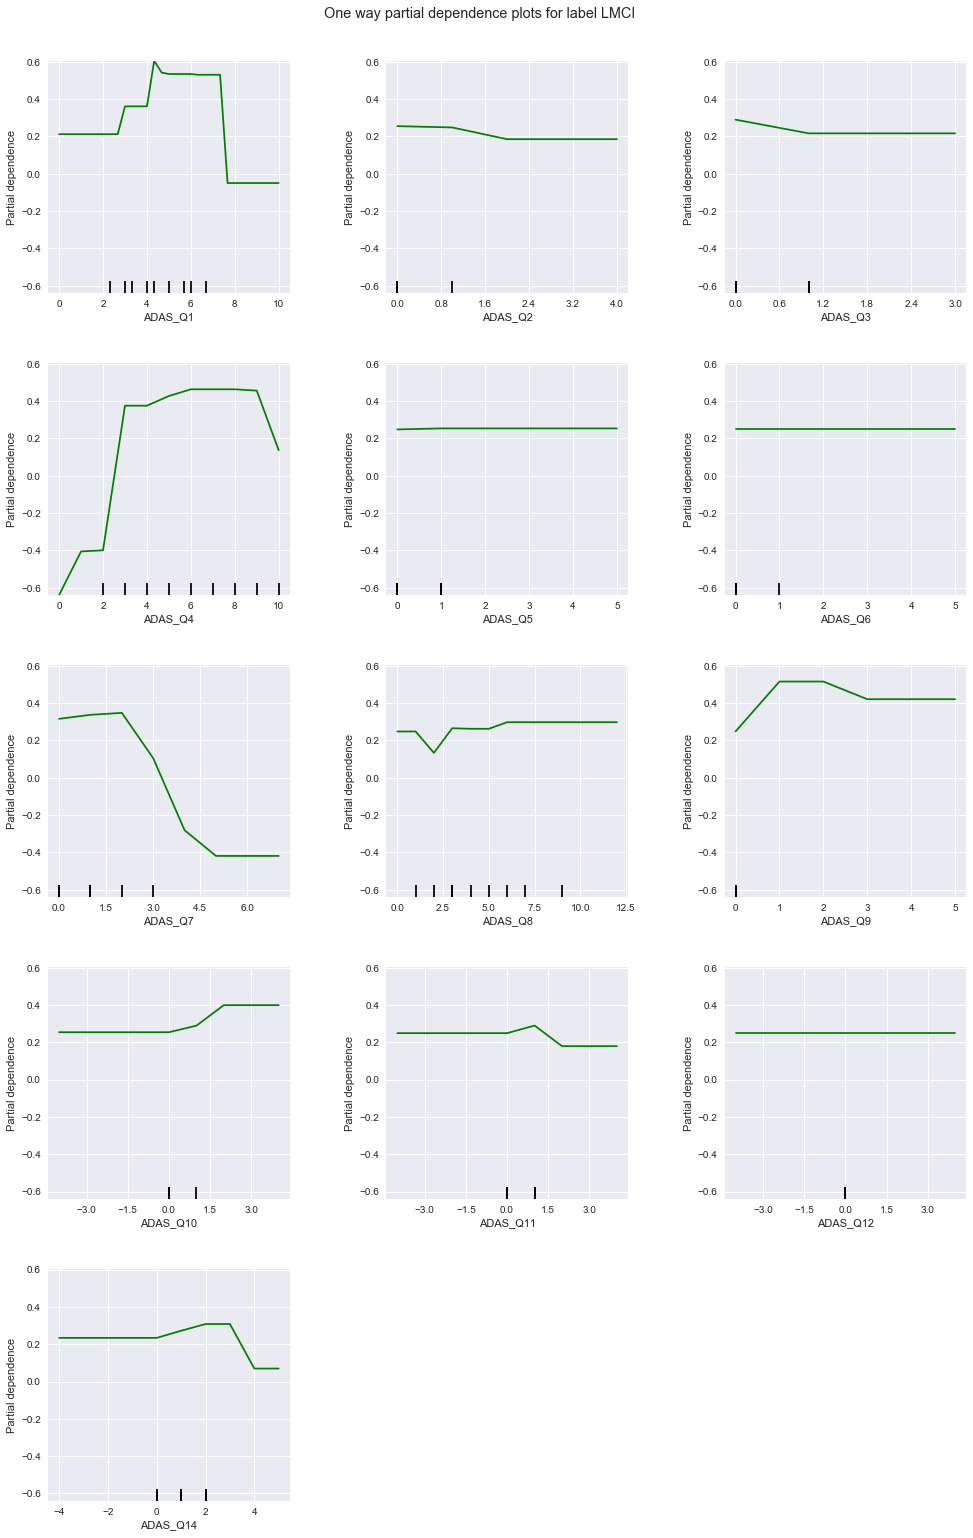

**************************************************


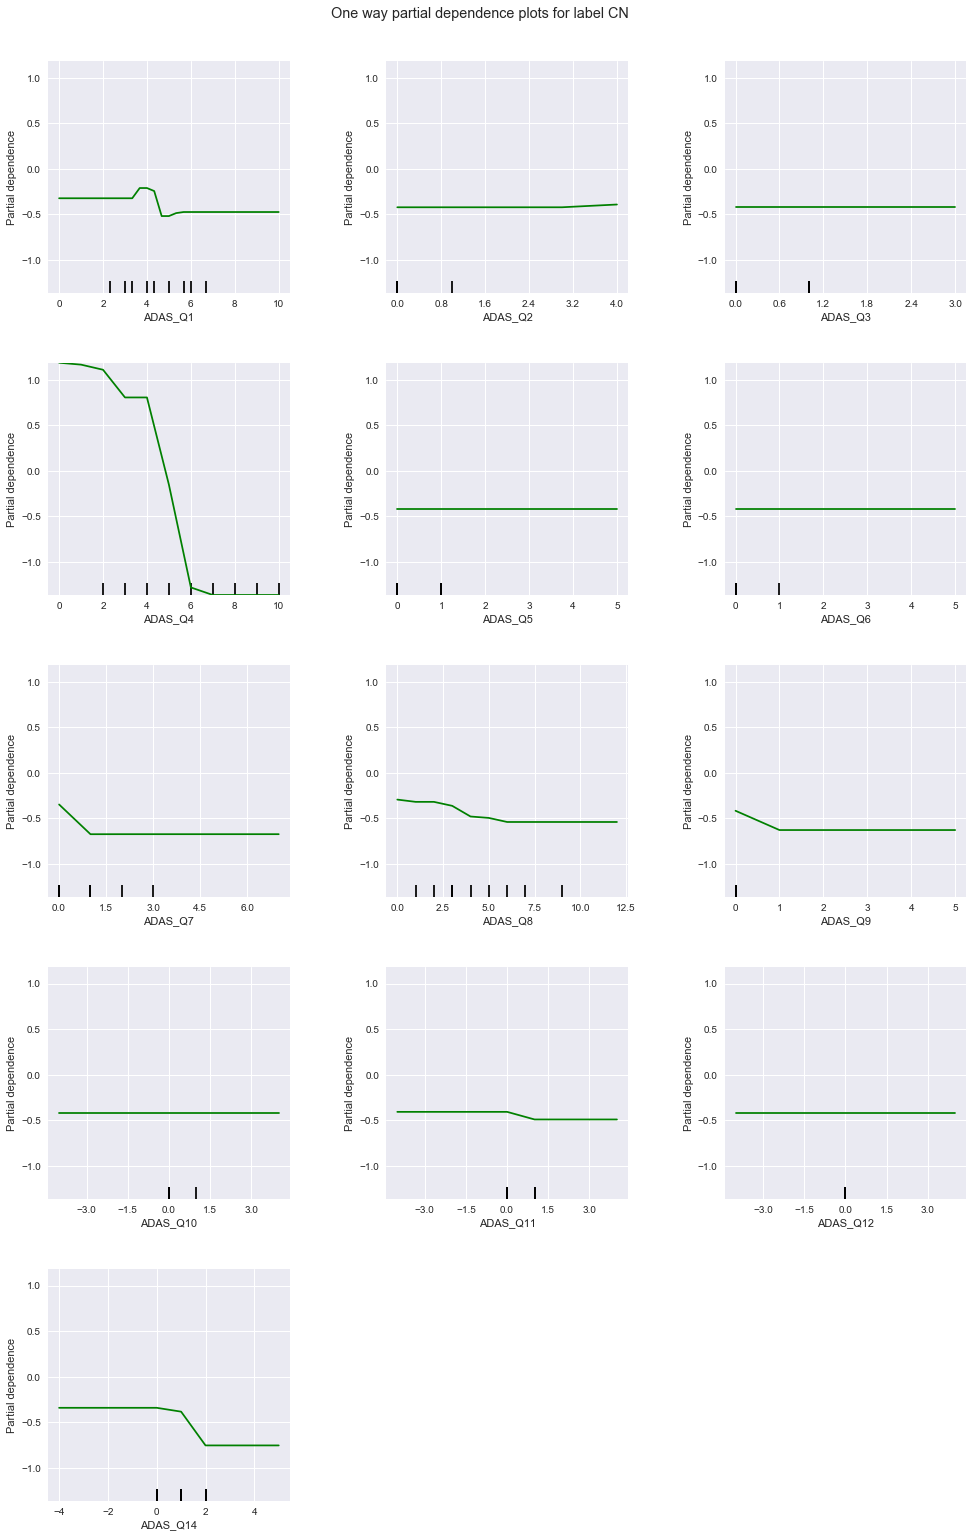

In [99]:
names = X_train.columns
features = range(0,13)

for cat in y_train.unique():
    print("*" * 50)
    fig, axs = plot_partial_dependence(cv_gbm, X_train, features, label = cat, feature_names=names)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 25)
    plt.suptitle("One way partial dependence plots for label {}".format(cat))
    plt.subplots_adjust(top=0.95)  # tight_layout causes overlap with suptitle
    plt.savefig("{}_ADASPartialDependence.png".format(cat))
    plt.show()

From the above charts, the degree of correlation and applicable response values of each question to each diagnosis are summarized in this table:

| ADAS Q# | CN | LMCI | AD   |
|------|------|------|------|
|   1  |  weak, lower values     | strong, low to mid values     |  strong, higher values   |
|   2  |  uniform    |  strong, high values    |   uniform  |
|   3  |  uniform   |  uniform    |  uniform   |
|   4  |  strong, low values    |   strong, high values   |   strong, high values  |
|   5  |  uniform    |   uniform   |  uniform   |
|   6  |  uniform    |   uniform   |  uniform   |
|   7  |  weak, low values    |   strong, low values   |  strong, high values   |
|   8  |  strong, low values    |   uniform   |  uniform   |
|   9  |  uniform    |   strong, high values   |   uniform  |
|   10  |  uniform    |  uniform    |  uniform   |
|   11  |  weak, low values    |  uniform    |   weak, high values  |
|   12  |  uniform    |    uniform  |   uniform  |
|   14  |  weak, low values    |   strong, low values   |   strong, high values  |


Among these, questions 1, 4, 7, and 14 seem to be sensitive to all diagnoses - 4 is particularly so. Questions 2 and 9 are strongly correlated to LMCI only, while question 8 is correlated to CN only. No question is strongly correlated to only AD. Based on the above, we train a GBM (1) on only questions 1, 4, 7, and 14, followed by (2) questions 1, 2, 4, 7, 8, 9, and 14.

In [100]:
adas_subset = ["1", "4", "7", "14"]
adas_subset = ["ADAS_Q" + s for s in adas_subset]
X_subset = X_train[adas_subset]
X_subset_test = X_test[adas_subset]

In [101]:
models = {'GBM': GradientBoostingClassifier()}

# Parameters
params = {'GBM': {'learning_rate': [0.05, 0.1, 0.15, 0.2], 'n_estimators': [5 * x for x in range(2, 10)]}}

# Grid search
gsp = GridSearchPipe(models, params)
gsp.fit(X_subset, y_train, cv=10, refit=True, verbose=0)
res = gsp.score_summary()
res[:10]

/Users/justinlee/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,mean_score,max_score,std_score,learning_rate,n_estimators
17,GBM,0.631579,0.730314,0.781818,0.048436,0.15,15
16,GBM,0.631579,0.728629,0.796296,0.055383,0.15,10
9,GBM,0.631579,0.728562,0.796296,0.049334,0.10,15
8,GBM,0.614035,0.726708,0.796296,0.050781,0.10,10
18,GBM,0.631579,0.726676,0.800000,0.050542,0.15,20
24,GBM,0.631579,0.726676,0.781818,0.049316,0.20,10
21,GBM,0.614035,0.724888,0.818182,0.055321,0.15,35
15,GBM,0.614035,0.724856,0.818182,0.060087,0.10,45
26,GBM,0.614035,0.724856,0.818182,0.061218,0.20,20
11,GBM,0.631579,0.724825,0.800000,0.052335,0.10,25


In [12]:
cv_gbm = GradientBoostingClassifier(learning_rate=0.2, n_estimators=10)
cv_gbm.fit(X_subset, y_train)

cv_gbm.score(X_subset_test, y_test)

0.7232472324723247

Using only the four questions above, our new GBM with learning rate 0.2 and 10 estimators achieves an accuracy of 0.723, marginally better than the GBM with all questions as features.

We now take a look at another model that uses a wider subset comprised of questions 1, 2, 4, 7, 8, 9, and 14. These questions respond in some capacity to one or more of the diagnosis classes.

In [103]:
adas_subset_2 = ["1", "2", "4", "7", "8", "9", "14"]
adas_subset_2 = ["ADAS_Q" + s for s in adas_subset_2]
X_subset_2 = X_train[adas_subset_2]
X_subset_test_2 = X_test[adas_subset_2]

In [14]:
models = {'GBM': GradientBoostingClassifier()}

# Parameters
params = {'GBM': {'learning_rate': [0.05, 0.1, 0.15, 0.2], 'n_estimators': [5 * x for x in range(2, 10)]}}

# Grid search
gsp = GridSearchPipe(models, params)
gsp.fit(X_subset_2, y_train, cv=10, refit=True, verbose=0)
res = gsp.score_summary()
res[:10]

/Users/justinlee/anaconda2/envs/py3k/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,mean_score,max_score,std_score,learning_rate,n_estimators
19,GBM,0.596491,0.708337,0.777778,0.056152,0.15,25
7,GBM,0.614035,0.708172,0.796296,0.054997,0.05,45
12,GBM,0.614035,0.708106,0.796296,0.056464,0.10,30
20,GBM,0.614035,0.706455,0.777778,0.057586,0.15,30
26,GBM,0.614035,0.704701,0.796296,0.052903,0.20,20
15,GBM,0.611111,0.704502,0.767857,0.054983,0.10,45
27,GBM,0.614035,0.703015,0.796296,0.053590,0.20,25
28,GBM,0.614035,0.702783,0.759259,0.045174,0.20,30
25,GBM,0.631579,0.702619,0.777778,0.044256,0.20,15
14,GBM,0.596491,0.701030,0.796296,0.063266,0.10,40


In [15]:
cv_gbm = GradientBoostingClassifier(learning_rate=0.15, n_estimators=15)
cv_gbm.fit(X_subset_2, y_train)

cv_gbm.score(X_subset_test_2, y_test)

0.69741697416974169

To summarize: compared to our full-questionnaire classification accuracy of 0.668, our first modified classifier performed slightly better at 0.723, while our seccond performed slightly worse at 0.697. 

## Logistic Regression

We perform the same analysis as above but with logistic regression. We will then examine the statistical significance of each predictor and compare these results against the above. 

In [111]:
# Read data
data = pd.read_csv('../data/data_all.csv', low_memory=False);

# Create 'year' variable
data['YEAR'] = data['EXAMDATE'].apply(lambda x: x[:4])

# Subset data to baseline observations for ADNI 1
data = data.loc[(data['VISCODE'] == "bl") & (data['ORIGPROT'] == "ADNI1"), :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [112]:
# =========================
# Fit logistic models
# =========================

lambdas = [10**x for x in range(-5,6)]

log_cv = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2')

In [113]:
log_cv_result = log_cv.fit(X_train, y_train)
C = log_cv_result.C_
#print("The cross validated parameter is: " + str(C))
#log_cv.score(X_test, y_test)

In [114]:
### ROC Curve ### 
# Binarize the output
y_test_original = y_test
y_train_original = y_train

y_test = label_binarize(y_test, classes=['CN','LMCI','AD'])
y_train = label_binarize(y_train, classes=['CN','LMCI','AD'])

n_classes = y_test.shape[1]



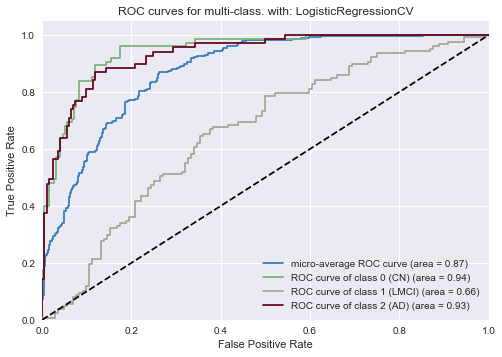

In [115]:
model = log_cv_result

ax=plt.gca()

# Learn to predict each class against the other
classifier = OneVsRestClassifier(model)

y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve

ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

for i,label in zip(range(n_classes),['CN','LMCI','AD']):
    ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
                                   ''.format(i,label, roc_auc[i]));

ax.plot([0, 1], [0, 1], 'k--');
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves for multi-class. with: {0}'.format(str(model.__class__).split('.')[-1].strip("'>")))
ax.legend(loc="lower right");

plt.show()

As was the case in the logistic regressin for all features, the ROC curve for our ADAS-quesionnaire logistic classifier shows good performance on the two extreme diagnoses (Cognitively Normal and Alzheimer's Disease) and slightly worse performance on the middle diagnosis (LMCI). 

We now examine the significance of individual ADAS questions as we did for the GBM.

In [116]:
### Significance of coefficients 

y_test = y_test_original 
y_train = y_train_original
X_train_original = X_train
X_test_original = X_test

names = X_train.columns 

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# print(len(X_train), len(X_test), len(y_train), len(y_test))



In [128]:
import random

def bootstrap_sample(num_samples, max_index, dataset, y_set):
    indices = []

    for index in range(num_samples):
        indices.append(random.randint(0, max_index - 1))
    
    x = []
    y = []
    for index in indices:
        x.append(dataset[index])  
        y.append(y_set[index])
    return np.array(x), y

num_iterations = 100

beta_coeff = 0
beta_intercept = 0

beta_coeff_sd_list = []
beta_intercept_sd_list = []


for n in range(num_iterations):
    
    X_train_sample, y_train_sample = bootstrap_sample( len(X_train), len(y_train), X_train, y_train)
    y_train_sample = np.array(y_train_sample).reshape((-1, ))
    
    logitm = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2', multi_class = 'ovr')
    logitm.fit (X_train_sample, y_train_sample)
    
    # The coefficients
    beta_coeff += logitm.coef_
    beta_intercept += logitm.intercept_
    

    beta_coeff_sd_list.append(logitm.coef_[0,:].tolist())
    beta_intercept_sd_list.append(logitm.intercept_.tolist())

beta_coeff_sd_list = np.array(beta_coeff_sd_list)

beta_intercept_sd_list = np.array(beta_intercept_sd_list)

beta_coeff /= num_iterations
beta_intercept /= num_iterations

beta_coeff_sd = np.std(beta_coeff_sd_list, axis = 0)
beta_intercept_sd = np.std(beta_intercept_sd_list, axis = 0)

# print(list(zip(beta_coeff_sd, names)))
# print(beta_intercept_sd)



In [127]:
from scipy.stats import t

t_interval = t.interval(0.9, len(y_train) - 1)
# print(t_interval)

significant = lambda x: x < t_interval[0] or x > t_interval[1]

signif_count = 0

signif_intercept = 0

betas = beta_coeff[0,:].tolist()

index = []
for n in range(len(betas)):
    beta_t = betas[n] / beta_coeff_sd[n]
#     print(n, beta_t)
    if significant(beta_t):
        signif_count += 1
        index.append(n)

        
# signif_intercept += significant(beta_intercept[0] / beta_intercept_sd[0])
# print(signif_count)
# print(signif_intercept)

# for i in index:
#     print(names[i])

We perform a t-test at the 90% level on the logistic regression model coefficients, using the result of 100-iteration averaged predictors. This yields the below results:

|Question | t-value|Significant at 90% ?|
|---------|----------|---------|
|1|  1.965 | Yes|
|2|  0.449 | No|
|3|  1.362 | No|
|4|  4.183 | Yes|
|5|  0.187 | No|
|6|  0.136 | No|
|7|  2.920 | Yes|
|8|  0.634 | No|
|9|  1.098 | No|
|10| 0.251  | No|
|11|  1.441  | No|
|12| 0.493 | No|
|14| 1.846 | Yes|

We see that questions 1, 4, 7 and 14 are signficant at 90% (and with the close exception of 14, are also significant at 95%), just as before with our GBM. We will now train a new logistic regression model on these four features only.

In [120]:
adas_subset = ["1", "4", "7", "14"]
adas_subset = ["ADAS_Q" + s for s in adas_subset]
X_train = X_train_original[adas_subset]
X_test = X_test_original[adas_subset]


In [121]:
# =========================
# Fit logistic models
# =========================

lambdas = [10**x for x in range(-5,6)]

log_cv = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2')

In [122]:
log_cv_result = log_cv.fit(X_train, y_train)
C = log_cv_result.C_
print("The cross validated parameter is: " + str(C))
log_cv.score(X_test, y_test)

The cross validated parameter is: [ 0.1  1.   1. ]


0.7232472324723247

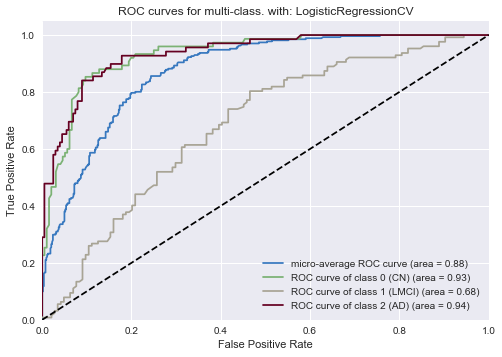

In [123]:
### ROC Curve ### 
# Binarize the output
y_test_original = y_test
y_train_original = y_train

y_test = label_binarize(y_test, classes=['CN','LMCI','AD'])
y_train = label_binarize(y_train, classes=['CN','LMCI','AD'])

n_classes = y_test.shape[1]

model = log_cv_result

ax=plt.gca()

# Learn to predict each class against the other
classifier = OneVsRestClassifier(model)

y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve

ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

for i,label in zip(range(n_classes),['CN','LMCI','AD']):
    ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
                                   ''.format(i,label, roc_auc[i]));

ax.plot([0, 1], [0, 1], 'k--');
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves for multi-class. with: {0}'.format(str(model.__class__).split('.')[-1].strip("'>")))
ax.legend(loc="lower right");

plt.show()

On the whole, using just the four questions yields a slightly better logistic model than before. While our new model yields comparable results to the whole-questionnaire model for the CN and AD classes, we observe marginally improved performance for the LMCI class (0.68 from 0.66 previously). Overall, the improved performance in this new classifier is in line with our observations in the GBM analysis. The logistic regression analysis gives us the added benefit of having a way to quantify the statistical significance of each predictor.